# [Lab Session 4](deconvolution.ipynb)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

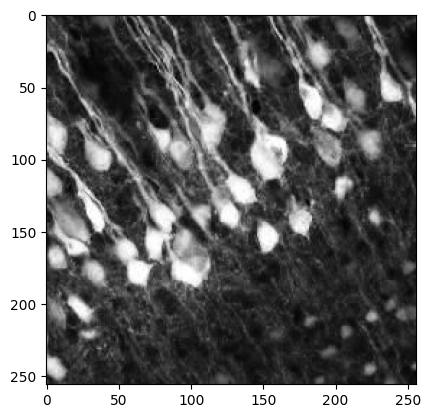

In [36]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [37]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

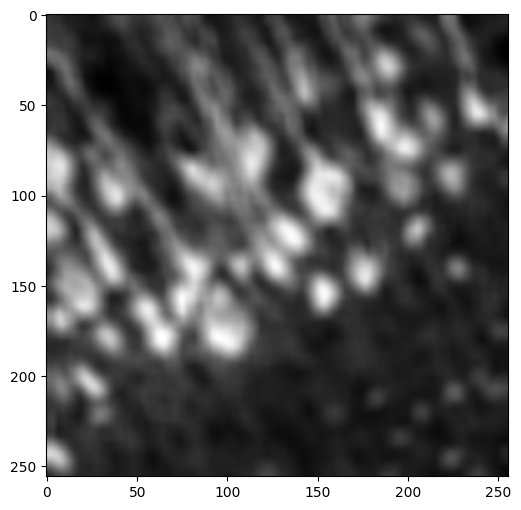

In [38]:
blurred = conv(img, psf, mode='same', boundary='symm')

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap='gray')

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

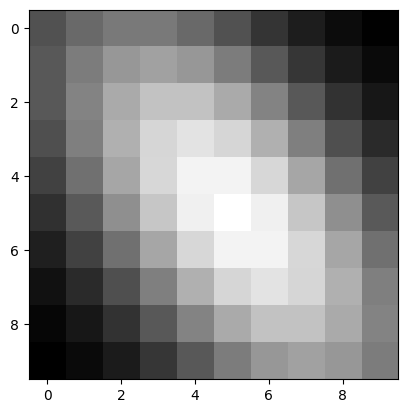

In [39]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

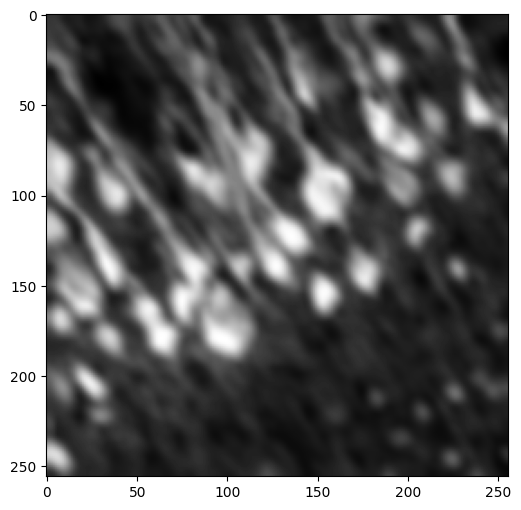

In [40]:
# PSF erzeugen
gauss_psf = create_psf(psf_size)

# PSF normieren 
gauss_psf = gauss_psf / gauss_psf.sum()

# Bild mit PSF falten 
blurred_gauss = conv(img, gauss_psf, mode='same', boundary='symm')

# Ergebnis anzeigen
plt.figure(figsize=(6,6))
plt.imshow(blurred_gauss, cmap='gray')

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [67]:
def richardson_lucy_deconvolution(image, psf, n_iterations): # um ein unscharfes Bild wieder scharf zu machen
    img_deconv = np.full(image.shape, 0.5) # jeder Wert wird Schritt für Schritt verbessert; 0.5 ist der Startwert (alle Pixel = 0.5 = grau)
    h = img_deconv

    # geflippte PSF für die Rückfaltung
    psf_flipped = np.flip(psf) # PSF wird um 180° gedreht

    for t in range(n_iterations):
        conv_h_psf = conv(h, psf, mode='same', boundary='symm') # Bild wird unscharf gemacht
        relative_blur = image / conv_h_psf # Bilder werden verglichen
        correlation = conv(relative_blur, psf_flipped, mode='same', boundary='symm') #Fehler wird über PSf verteilt
        h *= correlation # Bild wird verbessert

    
    img_deconv = img_deconv.clip(0,1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

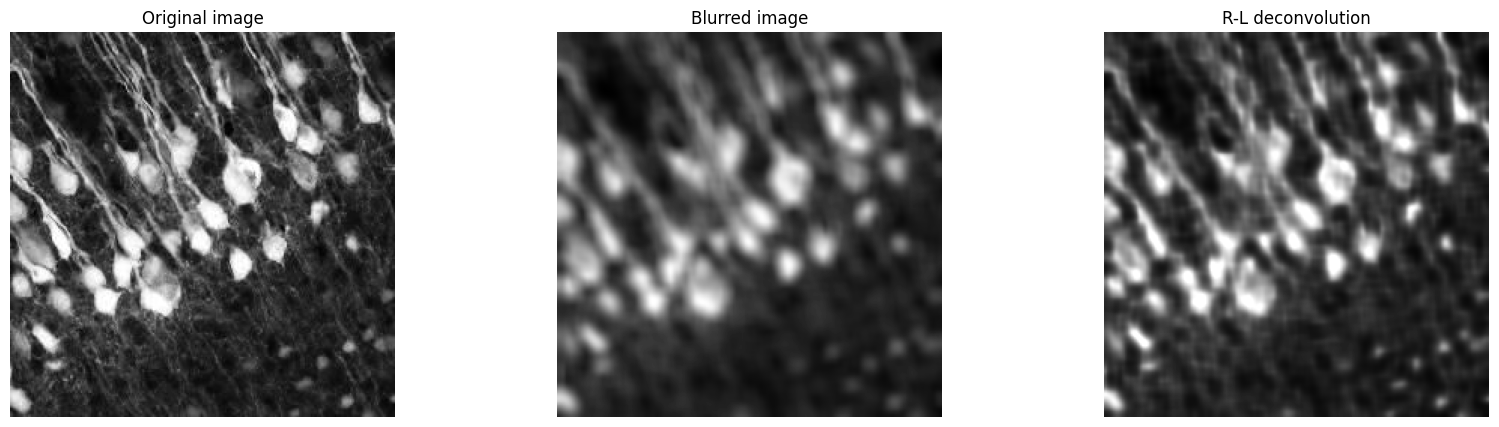

In [70]:
# Original Bild anzeigen 
#plt.imshow(img, 'gray')

# unscharfes Bild azeigen
#blurred = conv(img, psf, mode='same', boundary='symm')
#plt.imshow(blurred, cmap='gray')

# unscharf mit Filter wieder scharf machen
deconv_img = richardson_lucy_deconvolution(blurred, psf, n_iterations=20)

# alle Bilder nebeneinander darstellen
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred, 'gray')
plt.title('Blurred image')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_img, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [43]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

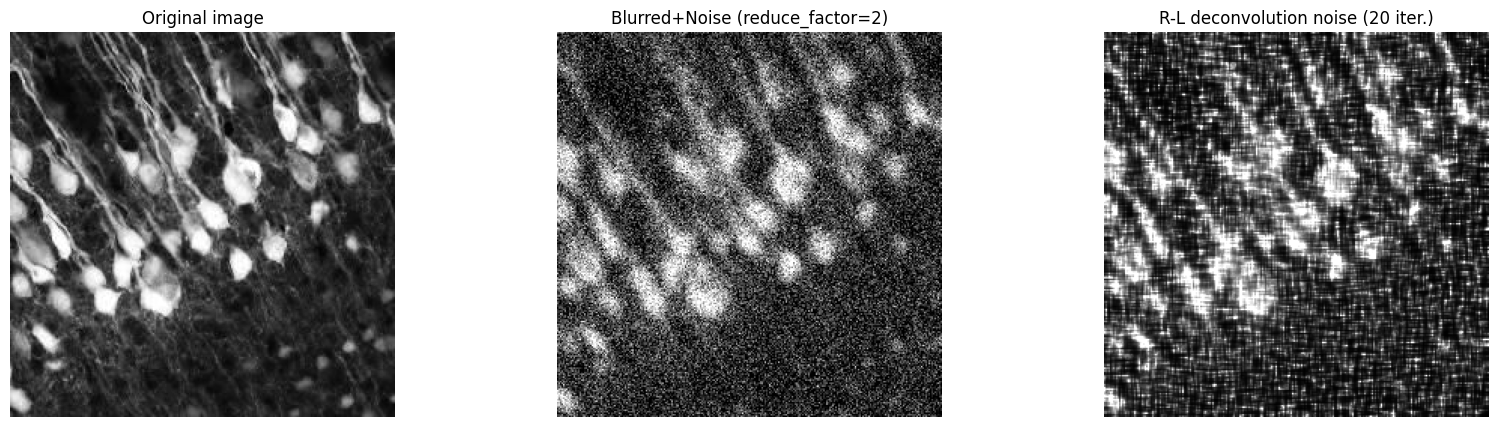

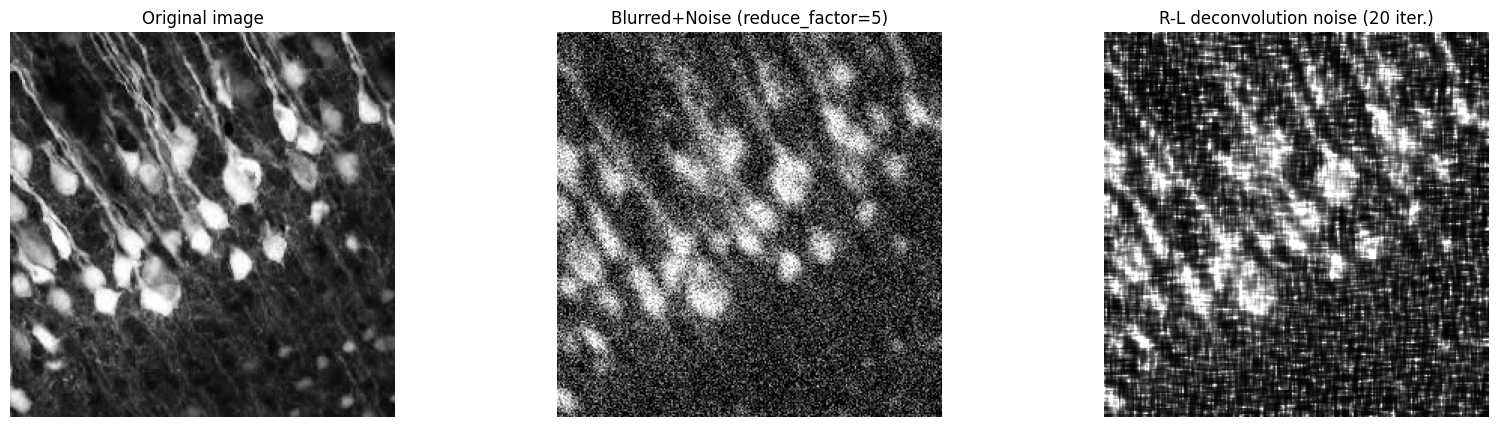

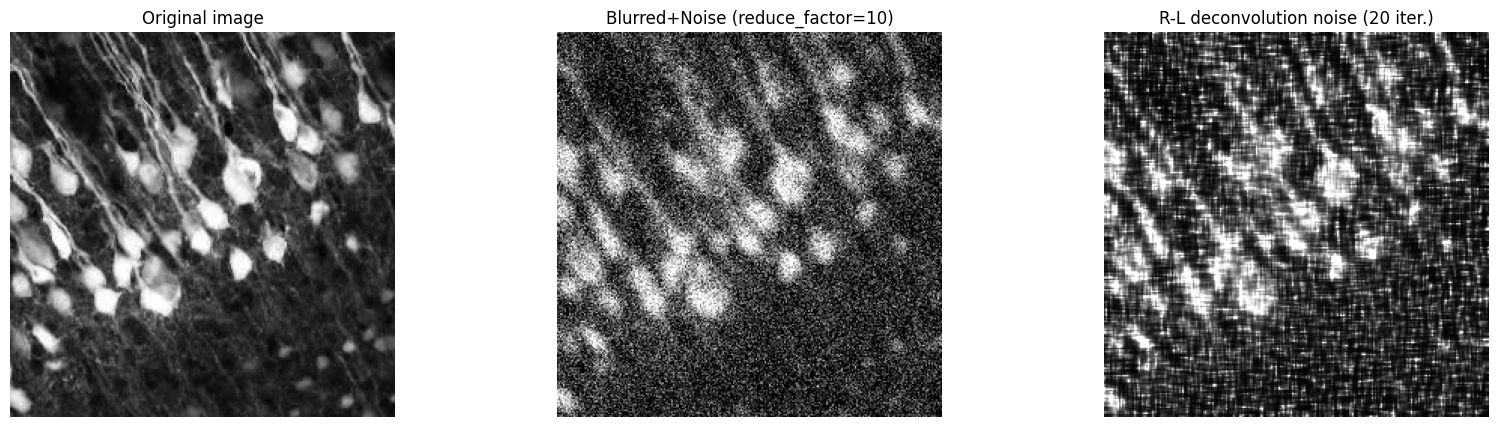

In [ ]:
# Rauschen zu Bild hinnzufügen
img_noise = blurred_gauss + noise

img_noise = np.clip(img_noise, 0, 1) # intensitätsbereich definieren

#verschieden Rauschlevel ausprobieren
for reduce_factor in [2, 5, 10]:

    n_iterations = 20

# R-L faltung anwenden
    deconv_img_noise = richardson_lucy_deconvolution(img_noise, psf, n_iterations)

# alle Bilder nebeneinander darstellen
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img, 'gray')
    plt.title('Original image')

    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(img_noise, 'gray')
    plt.title(f'Blurred+Noise (reduce_factor={reduce_factor})')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(deconv_img_noise, 'gray')
    plt.title(f'R-L deconvolution noise ({n_iterations} iter.)')
    plt.show()





**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

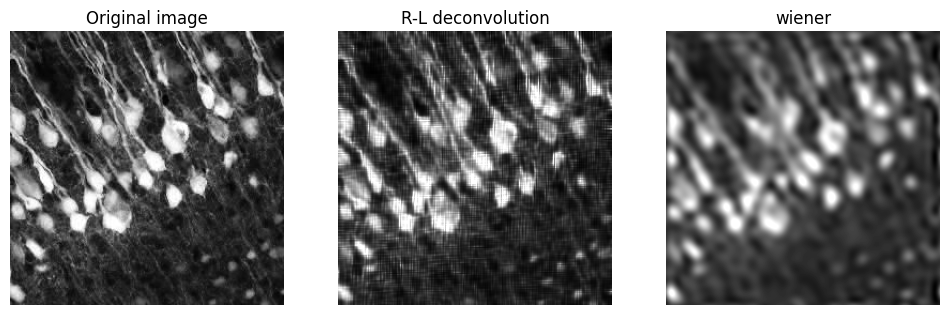

In [56]:
img_psf = conv(img, psf, mode='same', boundary='symm')

wiener_restored= wiener(img_psf,psf, balance=2, clip=True)


# alle Bilder nebeneinander darstellen
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(deconv_img, 'gray')
plt.title('R-L deconvolution')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(wiener_restored, 'gray')
plt.title('wiener')
plt.show()

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

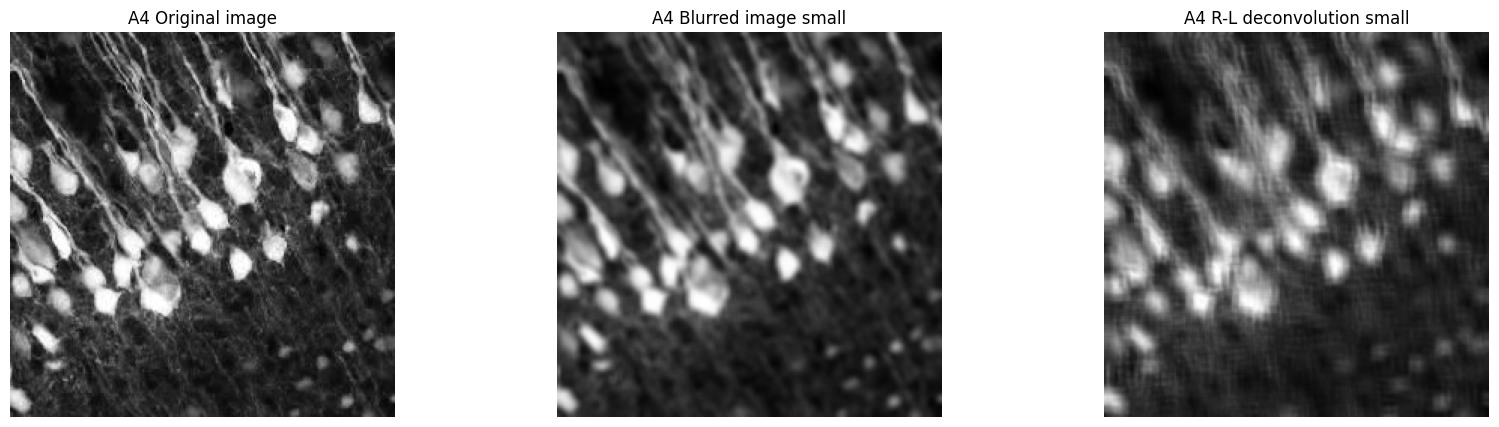

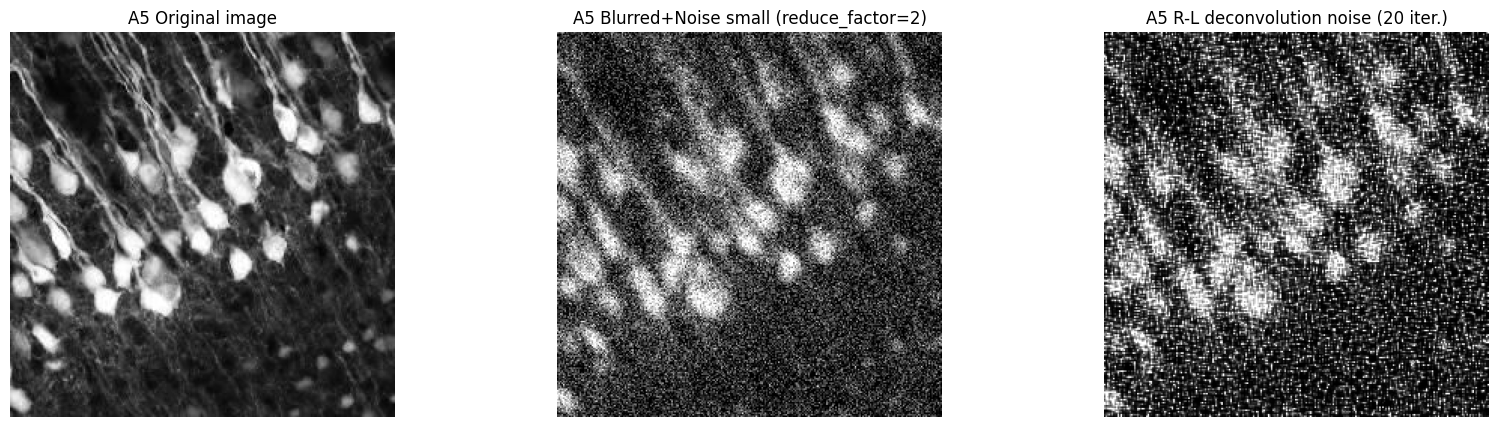

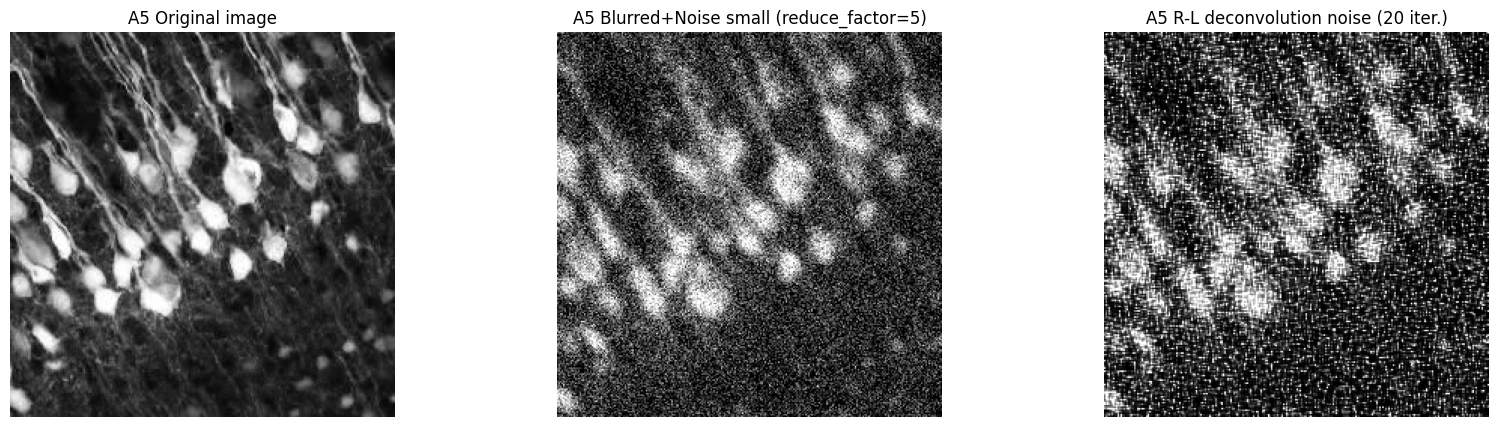

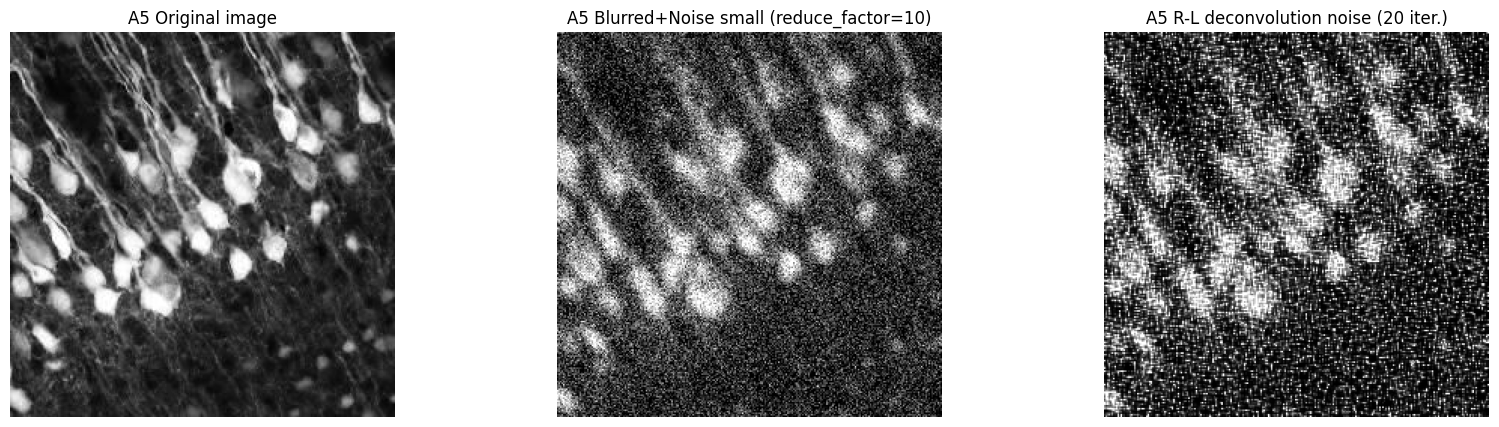

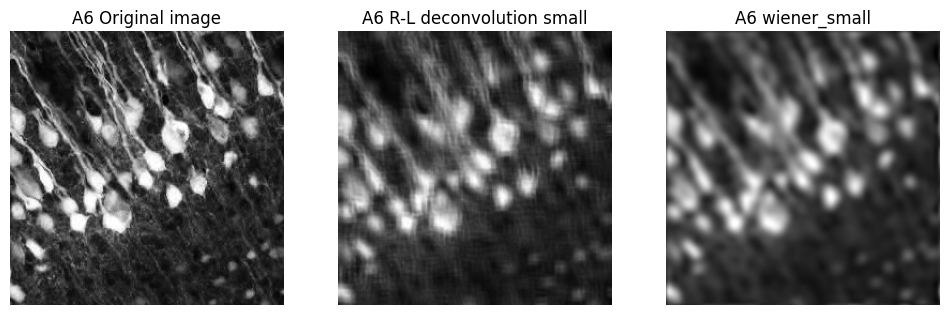

In [61]:
psf_size_small = 5
psf_small = np.ones((psf_size_small, psf_size_small))/ psf_size_small**2

#aufgabe 4

# unscharf mit Filter wieder scharf machen
blurred_small = conv(img, psf_small, mode='same', boundary='symm')
deconv_img_small = richardson_lucy_deconvolution(blurred, psf_small, n_iterations=250)

# alle Bilder nebeneinander darstellen
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('A4 Original image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred_small, 'gray')
plt.title('A4 Blurred image small')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_img_small, 'gray')
plt.title('A4 R-L deconvolution small')
plt.show()

# Aufagbe 5
# Rauschen zu Bild hinnzufügen
img_noise_small = blurred_small + noise

img_noise_small = np.clip(img_noise, 0, 1) # intensitätsbereich definieren

#verschieden Rauschlevel ausprobieren
for reduce_factor in [2, 5, 10]:

    n_iterations = 20

# R-L faltung anwenden
    deconv_img_noise_small= richardson_lucy_deconvolution(img_noise, psf_small, n_iterations)

# alle Bilder nebeneinander darstellen
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img, 'gray')
    plt.title('A5 Original image')

    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(img_noise_small, 'gray')
    plt.title(f'A5 Blurred+Noise small (reduce_factor={reduce_factor})')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(deconv_img_noise_small, 'gray')
    plt.title(f'A5 R-L deconvolution noise ({n_iterations} iter.)')
    plt.show()

# Aufagbe 6
img_psf_small = conv(img, psf_small, mode='same', boundary='symm')

wiener_restored_small= wiener(img_psf,psf_small, balance=2, clip=True)


# alle Bilder nebeneinander darstellen
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('A6 Original image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(deconv_img_small, 'gray')
plt.title('A6 R-L deconvolution small')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(wiener_restored_small, 'gray')
plt.title('A6 wiener_small')
plt.show()

**[Task 8.]()** Use a wrong PSF to restore the image

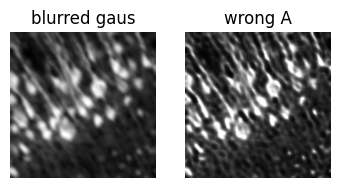

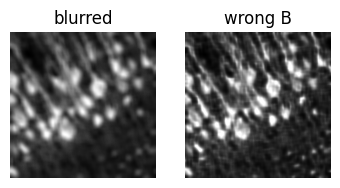

In [66]:
psf_uniform = np.ones((psf_size, psf_size)) / psf_size**2
wrong_RL_A = richardson_lucy_deconvolution(blurred_gauss, psf_uniform, n_iterations=30)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred_gauss, 'gray')
plt.title('blurred gaus')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(wrong_RL_A, 'gray')
plt.title('wrong A')
plt.show()



wrong_RL_B = richardson_lucy_deconvolution(blurred,psf_uniform, n_iterations=30)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(blurred, 'gray')
plt.title('blurred')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(wrong_RL_B, 'gray')
plt.title('wrong B')
plt.show()